# Facebook Regression

The input variables:

* **total_followers**: The number of followers of the group.
* **type**: Specifies whether it is of type "**photo", "status", or "link".**
* **category**: There are** three distinct categories 1,2, and 3.**
* **month**: The month that the post was created.
* **weekday**: The day of the week that the post was created.
* **paid**: A 0/1 flag indicating whether the post was a paid-for promotion.

*The output variables:*

* **comment**: The number of comments that the post generated.
* **like**: The number of likes that the post generated.
* **share**: The number of shares that the post generated.

Now do the following:

1. Build a regression model by minimizing the **mean squared error (MSE)** to predict any one of:
    1. comments,
    2. likes,
    3. shares
2. In building,  I want to:
    1. visualize histograms or relationships between features and response using scatterplots
    2. preprocess data:
    3. standartize / normalize
    4. add higher degrees and interactions into the model?
    5. K-fold cross validation; is the group important and should be grouped CV?
3. Using your model, quantify how much the different input variables predict the influence of a post. Is there any interesting or unexpected behavior that your model predicts?



In [26]:
## SETTING UP
# imports
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
import pylab as pl
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import numpy as np

# allow plots to appear directly in the notebook
%matplotlib inline

#import data
data =  pd.read_csv("/Users/tomereldor/PycharmProjects/CS156ML/facebook_train.csv")
data.head()

,total_followers,type,category,month,weekday,hour,paid,comment,like,share
0,124050,Photo,3,6,4,17,1,3,77,16
1,132556,Photo,2,8,3,24,0,11,313,50
2,92786,Photo,2,2,6,17,1,2,145,39
3,135632,Photo,1,9,2,1,0,2,299,49
4,139540,Link,1,12,3,17,1,7,229,21


## DATA PREPROCESSING
* Converting stinrgs to dummy variables
* Adding 1s
* Rescaling to standartize / normalize
* Prepare 2nd degree polynomial and interaction columns for regression

In [28]:
## DATA PREPROCESSING

data['1s'] = 1 # we would need a column of ones for linear regression
data['weekend'] = (data['weekday'] > 5)


# converting categorical into dummies:
data['type_post'] = data['type'].astype('category').cat.codes
data['type*cat'] = (data['type_post']) * (data['category'])




## adding higher degrees (for fitting on nonlinear lines) and interactions
for col in ['hour','month','weekday']:
    for order in [2]:
        colname = str(col) + "^" + str(order)
        #print colname
        data[colname] = data[col]**order
#data.head()

#cols = list(data)
cols =  ['total_followers','type_post', 'type*cat', 'category', 'paid', 'month', 'weekday', 'hour','weekend', 'hour^2', 'month^2', 'weekday^2', 'comment', 'like', 'share']

#reorder columns
#cols.insert(2, cols.pop(cols.index('type_post')))
#cols.insert(4, cols.pop(cols.index('type*cat')))
#cols.insert(-3, cols.pop(cols.index('1s')))
data = data.ix[:, cols]
data.head(20)

,total_followers,type_post,type*cat,category,paid,month,weekday,hour,weekend,hour^2,month^2,weekday^2,comment,like,share
0,124050,1,3,3,1,6,4,17,False,289,36,16,3,77,16
1,132556,1,2,2,0,8,3,24,False,576,64,9,11,313,50
2,92786,1,2,2,1,2,6,17,True,289,4,36,2,145,39
3,135632,1,1,1,0,9,2,1,False,1,81,4,2,299,49
4,139540,0,0,1,1,12,3,17,False,289,144,9,7,229,21
5,138969,1,3,3,1,12,5,17,False,289,144,25,3,284,31
6,124025,1,3,3,0,6,3,18,False,324,36,9,10,240,28
7,131431,2,4,2,1,7,6,20,True,400,49,36,7,16,1
8,137820,1,1,1,1,11,7,16,True,256,121,49,21,490,90
9,137553,2,4,2,0,11,4,17,False,289,121,16,2,96,15


In [31]:
input_vars =  ['total_followers','type_post', 'type*cat', 'category', 'paid', 'month', 'weekday', 'hour','weekend', 'hour^2', 'month^2', 'weekday^2'] #'month^3'...
output_vars = ['comment','like','share']

x = np.array(data[input_vars])
y = data['like']

#print, for verification
data[input_vars].head()

## print, to verify
#x[:10]
#y[:10]

,total_followers,type_post,type*cat,category,paid,month,weekday,hour,weekend,hour^2,month^2,weekday^2
0,124050,1,3,3,1,6,4,17,False,289,36,16
1,132556,1,2,2,0,8,3,24,False,576,64,9
2,92786,1,2,2,1,2,6,17,True,289,4,36
3,135632,1,1,1,0,9,2,1,False,1,81,4
4,139540,0,0,1,1,12,3,17,False,289,144,9


In [86]:
cols_to_transform = ['total_followers','type_post', 'type*cat', 'category']
df_with_dummies = pd.get_dummies( columns = cols_to_transform )

TypeError: get_dummies() takes at least 1 argument (1 given)

In [ ]:
#[ur dataframe].iloc(row index, col index)
#Ex: df.iloc(:, 1:9)
#Ex2: df.iloc(:, [‘type’])

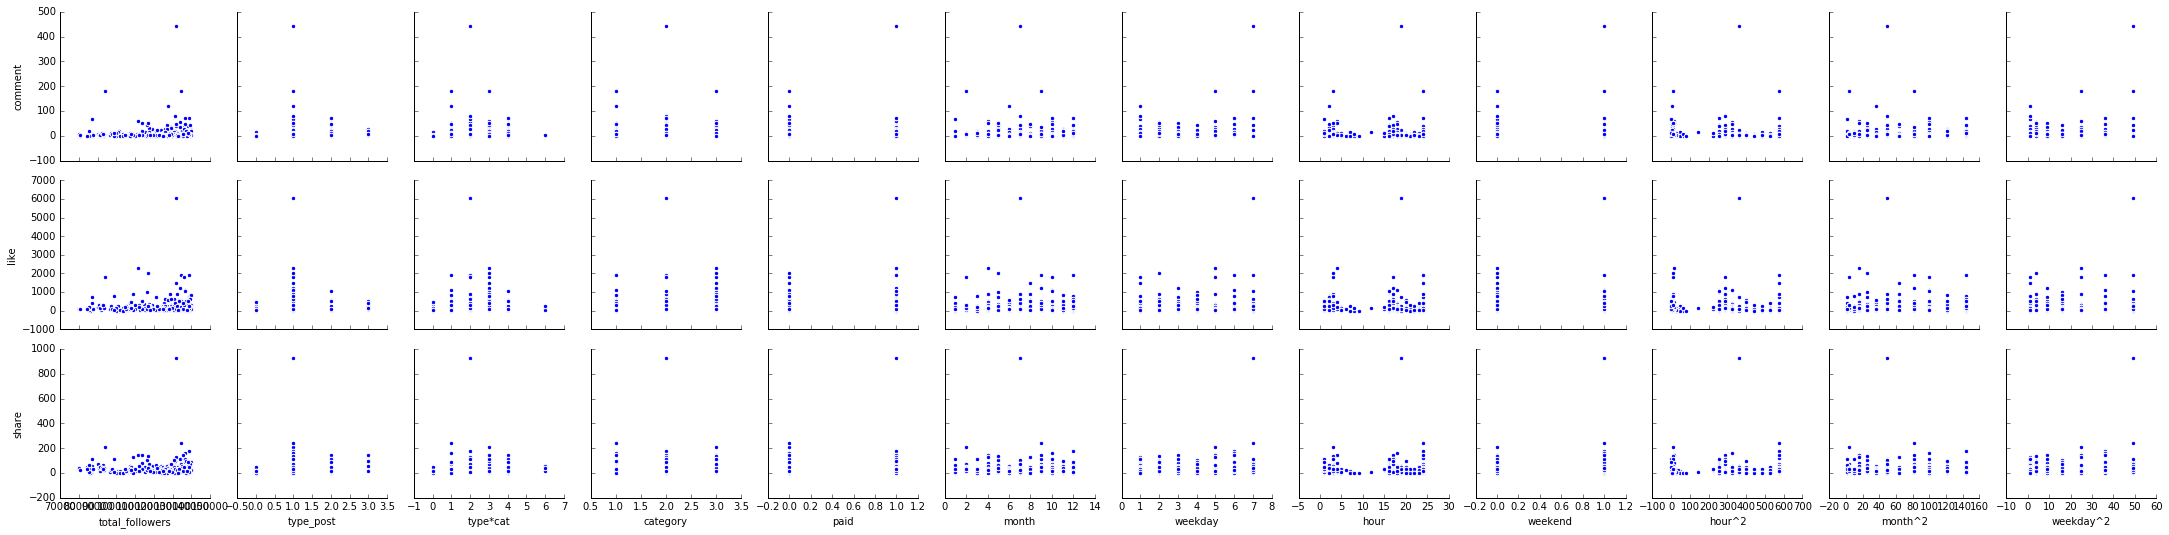

In [32]:
# Data Exploring
#visualize histograms or relationships between features and response using scatterplots
sns.pairplot(data, x_vars=input_vars, y_vars=output_vars)#, size=7, aspect=0.7)

In [37]:
## STANDARTIZE DATA 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x_s = scaler.transform(x)
x_s[:20]

array([[ 0.03627935, -0.18021378,  0.84145804,  1.33483787,  1.57558121,
        -0.33074599,  0.03597344,  0.34818248, -0.59965744,  0.10553418,
        -0.54582578, -0.20363651],
       [ 0.55552614, -0.18021378, -0.02848686,  0.16501307, -0.63468642,
         0.27157584, -0.4740785 ,  1.19844531, -0.59965744,  1.51652448,
         0.05562142, -0.6376134 ],
       [-1.87222425, -0.18021378, -0.02848686,  0.16501307,  1.57558121,
        -1.53538965,  1.05607731,  0.34818248,  1.66761878,  0.10553418,
        -1.23319402,  1.03629746],
       [ 0.74329985, -0.18021378, -0.89843176, -1.00481173, -0.63468642,
         0.57273675, -0.98413044, -1.59527542, -0.59965744, -1.31037246,
         0.4207858 , -0.94759689],
       [ 0.9818628 , -2.41599097, -1.76837666, -1.00481173,  1.57558121,
         1.4762195 , -0.4740785 ,  0.34818248, -0.59965744,  0.10553418,
         1.77404201, -0.6376134 ],
       [ 0.94700623, -0.18021378,  0.84145804,  1.33483787,  1.57558121,
         1.4762195 ,  

In [38]:
## ADD INTERACTION & 2nd Degree Columns
#from sklearn.preprocessing import PolynomialFeatures
# PolynomialFeatures (prepreprocessing)
#poly = PolynomialFeatures(degree=2)
#X_poly = poly.fit_transform(x)
#
#target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(data.columns,p) for p in poly.powers_]]
#output_df = pd.DataFrame(X_spoly, columns = target_feature_names)
#output_df.head()

### After Data Prep: Seperate a test set

In [49]:
testset_portion = 0.15

data_train = data[int(testset_portion*len(data)):]
data_test = data[:int(testset_portion*len(data))]

print(len(data),len(data_train), len(data_test))

x_train = x[:int(testset_portion*len(x))]
x_test = x[int(testset_portion*len(x)):]
y_train = y[:int(testset_portion*len(y))]
y_test = y[int(testset_portion*len(y)):]

x_s_train = x_s[:int(testset_portion*len(x))]
x_s_test = x_s[int(testset_portion*len(x)):]

(397, 338, 59)


## Run Learning Model

In [64]:
# Create linear regression object
#from sklearn.linear_model.LinearRegression()
linreg = LinearRegression()

# Train the model using the training sets
linreg.fit(x_s_test,y_test)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
# Let's see predictions for the first 10 instances
print linreg.predict(x_s[:20])
print np.array(y[:20])

[ 372.28234662  198.27269923  263.56689181  129.79593548  181.63982171
  365.83582839  260.61357407  376.87064362  381.62799727  141.42176299
   57.544536    171.51116466  220.47064398  322.42730047  254.31557346
  159.54444535  328.73298507  424.38650704  460.53067942  214.14655323]
[  77  313  145  299  229  284  240   16  490   96   36   48  399  189  243
 1826  153  131  372   63]


### First pass: verifying 

In [70]:
# Compute RMSE on training data
# p = np.array([linreg.predict(xi) for xi in x])
p = linreg.predict(x_test)
# Now we can constuct a vector of errors
err = abs(p-y_test)

# Let's see the error on the first 10 predictions
print err[:10]

59    1.878179e+07
60    1.986448e+07
61    2.016215e+07
62    2.075111e+07
63    2.075860e+07
64    1.481683e+07
65    1.275136e+07
66    2.006897e+07
67    1.627124e+07
68    2.036085e+07
Name: like, dtype: float64


In [71]:
# Dot product of error vector with itself gives us the sum of squared errors
total_error = np.dot(err,err)
# Compute RMSE
rmse_train = np.sqrt(total_error/len(p))
print rmse_train

18570567.5253


In [72]:
# We can view the regression coefficients
print 'Regression Coefficients: \n', linreg.coef_


Regression Coefficients: 
[ 149.61169779   40.23603642  -67.02112662  103.36881432   50.44263294
 -184.16455795 -225.3525605    47.19648108  -14.94868775  -33.83440299
   67.85612339  264.5326568 ]


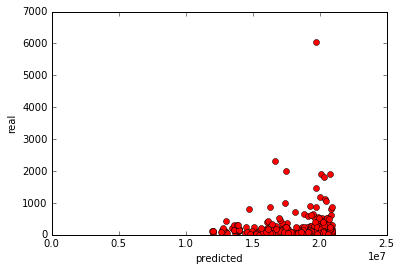

In [74]:
# Plot outputs
%matplotlib inline
pl.plot(p, y_test,'ro')
pl.plot([0,50],[0,50], 'g-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

## K-fold Cross Validation

In [76]:
# Now let's compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    linreg.fit(x[train],y[train])
    # p = np.array([linreg.predict(xi) for xi in x[test]])
    p = linreg.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
    
rmse_10cv = np.sqrt(xval_err/len(x))
rmse_10cv

417.56753062996665

## Model Performance Metrics

In [77]:
method_name = 'Simple Linear Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Method: Simple Linear Regression
RMSE on training: 18570567.5253
RMSE on 10-fold CV: 417.5675


In [78]:
# We can view the regression coefficients
print 'Regression Coefficients: \n', linreg.coef_

Regression Coefficients: 
[  1.59872934e-02   5.14396991e+01  -4.71765238e+01   1.04272665e+02
   1.22935645e+02  -1.53384988e+02  -1.10253535e+02   2.73401438e+00
  -1.06575901e+02  -3.41775308e-02   6.18731453e+00   1.77535161e+01]


In [256]:
for i in range(len(linreg.coef_)):
    print list(data)[i], linreg.coef_[i]

total_followers 0.0154870561336
type_post 57.3689917202
type*cat -51.1953972681
category 107.19492705
paid 126.64801637
month -210.413618766
weekday -164.111373768
hour 38.1628996269
weekend -102.682340646
hour^2 -3.21381423372
hour^3 0.0758134090068
month^2 17.3332192062
month^3 -0.570182180891
weekday^2 32.2516647592
weekday^3 -1.14703858646


In [80]:
## PUT INTO ONE

In [79]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
a=0.3
for name,met in [
        ('linear regression', LinearRegression()) #,
  #      ('lasso', Lasso(fit_intercept=True, alpha=a)),
  #      ('ridge', Ridge(fit_intercept=True, alpha=a)),
  #      ('elastic-net', ElasticNet(fit_intercept=True, alpha=a))
        ]:
    met.fit(x,y)
    # p = np.array([met.predict(xi) for xi in x])
    p = met.predict(x)
    e = p-y
    total_error = np.dot(e,e)
    rmse_train = np.sqrt(total_error/len(p))

    kf = KFold(len(x), n_folds=10)
    err = 0
    for train,test in kf:
        met.fit(x[train],y[train])
        p = met.predict(x[test])
        e = p-y[test]
        err += np.dot(e,e)

    rmse_10cv = np.sqrt(err/len(x))
    print('Method: %s' %name)
    print('RMSE on training: %.4f' %rmse_train)
    print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
    print "\n"

Method: linear regression
RMSE on training: 402.5523
RMSE on 10-fold CV: 417.5675




We'll measure its performance on the following metrics:
* Mean squared error (MSE)
* Mean absolute error (MAS)
* Median absolute error
* The coefficient of determination (or R²)

In [85]:
#imports 
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

#Predict again: pose only on test set
y_pred = linreg.predict(x_test)
y_true = y_test

# Mean squared error (MSE)
mse = mean_squared_error(y_true, y_pred)
mse

# Mean absolute error (MAS)
mean_abs_e = mean_absolute_error(y_true, y_pred)

# Median absolute error
med_abs_e = median_absolute_error(y_true, y_pred)

# The coefficient of determination (or R²)
r2 = r2_score(y_true, y_pred)  

print('MSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
print('MSE on TEST: %.4f' %mse)
print('Mean absolute error: %.4f' %mean_abs_e)
print('R^2 (The coefficient of determination): %.4f' %r2)

print "\n"

MSE on training: 402.5523
RMSE on 10-fold CV: 417.5675
MSE on TEST: 177999.7132
Mean absolute error: 192.6120
R^2 (The coefficient of determination): 0.0571




In [ ]:
##accuracy of clf
pr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred) 
plt.plot(fpr, tpr) 
plt.show() 
print 'plotting done' 
# print(result) 
import os os.system('say "your program has finished"')